All the functions are written under class quadSys() and solution of each part is shown below the class

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import quadrotor
import math

def plotResults(t,state,u):
    plt.figure(figsize=[9,6])

    plt.subplot(2,3,1)
    plt.plot(t, state[0,:])
    plt.legend(['X'])

    plt.subplot(2,3,2)
    plt.plot(t, state[2,:])
    plt.legend(['Y'])

    plt.subplot(2,3,3)
    plt.plot(t, state[4,:])
    plt.legend(["theta"])

    plt.subplot(2,3,4)
    plt.plot(t, state[1,:])
    plt.legend(['Vx'])
    plt.xlabel('Time [s]')

    plt.subplot(2,3,5)
    plt.plot(t, state[3,:])
    plt.legend(['Vy'])
    plt.xlabel('Time [s]')

    plt.subplot(2,3,6)
    plt.plot(t, state[5,:])
    plt.legend(['omega'])
    plt.xlabel('Time [s]')

    # we can also plot the control
    plt.figure()
    plt.plot(t[:-1], u.T)
    plt.legend(['u1', 'u2'])
    plt.xlabel('Time [s]')
    animateState(state,u)
    plt.show()
def animateState(state,u):
    quadrotor.animate_robot(state, u)    

def solve_LQR(A, B, Q, R, QN, N):

    list_of_P = []
    list_of_K = []
    list_of_P.append(QN)
    for i in range(N):
        P = list_of_P[-1]
        ki = -np.matmul(np.linalg.inv(R+np.matmul(B.transpose(),np.matmul(P,B))),np.matmul(np.matmul(B.transpose(),P),A))
        pi = Q + np.matmul(np.matmul(A.transpose(),P),A) + np.matmul(np.matmul(A.transpose(),P),np.matmul(B,ki))
        list_of_P.append(pi)
        list_of_K.append(ki)
    return list_of_P[::-1], list_of_K[::-1]

def solve_LQR_trajectory(A, B, Q, R, x_bar, N):

    K_gains = []
    k_feedforward = []
    
    Pn = Q
    pn = -Q@x_bar[:,[-1]]
    
    for i in range(N):
        qn = -Q@x_bar[:,[N-i-1]]
        Kn = -np.linalg.inv(R+B.transpose()@Pn@B)@B.transpose()@Pn@A
        P  = Q + A.transpose()@Pn@A + A.transpose()@Pn@B@Kn
        kn = -np.linalg.inv(R+B.transpose()@Pn@B)@B.transpose()@pn
        p  = qn + A.transpose()@pn + A.transpose()@Pn@B@kn
        
        Pn = P
        pn = p
        
        K_gains.append(Kn)
        k_feedforward.append(kn[:,0])
         
    return K_gains[::-1], k_feedforward[::-1]


class quadSys():
    def __init__(self):
        self.mass    = quadrotor.MASS
        self.length  = quadrotor.LENGTH
        self.inertia = quadrotor.INERTIA
        self.gravity = quadrotor.GRAVITY
        self.delta   = quadrotor.DELTA_T
        self.numS    = quadrotor.NUMBER_STATES
        self.numU    = quadrotor.NUMBER_CONTROLS
        self.horizon = 1000
        self.Kn = None
        self.trajectory = None
        self.xs = None
        self.us = None
        self.z1=None
        self.z2 = None
        self.Q = None
        self.R = None
        self.Q = None
        self.R = None
        self.u = None
        self.s = 50
        self.zS = None
        self.uS = None
    
    def get_next_state(self,z,u):

        x = z[0,0]
        vx = z[1,0]
        y = z[2,0]
        vy = z[3,0]
        theta = z[4,0]
        omega = z[5,0]

        dydt = np.zeros([quadrotor.NUMBER_STATES,1])
        dydt[0,0] = vx
        dydt[1,0] = (-(u[0,0] + u[1,0]) * np.sin(theta)) / quadrotor.MASS
        dydt[2,0] = vy
        dydt[3,0] = ((u[0,0] + u[1,0]) * np.cos(theta) - quadrotor.MASS * quadrotor.GRAVITY) / quadrotor.MASS
        dydt[4,0] = omega
        dydt[5,0] = (quadrotor.LENGTH * (u[0,0] - u[1,0])) / quadrotor.INERTIA
        z_next = z + dydt * quadrotor.DELTA_T

        return z_next

# Creating a trajectory for part 3
    def CreateTrajectory(self,angle,plot=False):
        self.trajectory = np.zeros((self.numS,self.horizon))  
        t = np.arange(0.,self.horizon*self.delta,self.delta)
        for n,i in enumerate(t):
            omega = 2*np.pi
            k = n/self.horizon
            Xbar = np.array(([math.cos(omega*k)],[-0.628*math.sin(omega*k)],[math.sin(omega*k)],[0.628*math.cos(omega*k)],[angle],[0]))
            self.trajectory[:,[n]] = Xbar
        if(plot):
            plt.plot(self.trajectory[0,:],self.trajectory[2,:])
            plt.xlim(-1.1,1.1)
            plt.ylim(-1.1,1.1)
            plt.axis('equal')
            plt.show()      

 # For all parts           
    def get_linearization(self,z,u):
        A = np.matrix([[1,self.delta,0,0,0,0],[0,1,0,0,-(1/self.mass)*(u[0,0]+u[1,0])*np.cos(z[4,0])*self.delta,0],[0,0,1,self.delta,0,0],[0,0,0,1,-(1/self.mass)*(u[0,0]+u[1,0])*np.sin(z[4,0])*self.delta,0],[0,0,0,0,1,self.delta],[0,0,0,0,0,1]])
        B = np.matrix([[0,0],[-np.sin(z[4,0])*self.delta/self.mass,-np.sin(z[4,0])*self.delta/self.mass],[0,0],[np.cos(z[4,0])*self.delta/self.mass,np.cos(z[4,0])*self.delta/self.mass],[0,0],[self.length*self.delta/self.inertia,-self.length*self.delta/self.inertia]])
        return A,B    

# For Part 1
    
    def stableController(self,state,i):
        return  1.00*(quadrotor.MASS*9.81) * np.ones([2,])/2    

 # For part 2   
    
    def inPlaceController(self,state,i):
        xStar = np.array([[0,0,0,0,0,0]]).T
        uStar =1.00*(quadrotor.MASS*9.81) * np.ones([2,1])/2 
        if(i==0):
            self.A,self.B = system.get_linearization(xStar,uStar)
            Q = np.diag([100,50,100,50,100,50])
            R = 0.01*np.eye(2)
            self.Pn,self.Kn = solve_LQR(self.A, self.B, Q, R, Q, self.horizon) 
        u =self.Kn[0]@(state.reshape([6,1])-xStar) + uStar
        return u.reshape([2,])    
 # For Part 3  
    def trajectoryController(self,state,i):
        
        if(i==0):
            xStar = self.trajectory[:,[i]]
            uStar = (quadrotor.MASS*9.81*np.ones([2,1])) 
            self.A,self.B = self.get_linearization(xStar,uStar)
            Q =np.diag([100000,50,100000,50,100000,50])
            R = 0.001*np.eye(2)
            self.Kn,self.kn = solve_LQR_trajectory(self.A, self.B, Q, R, self.trajectory, self.horizon)
        #u =self.Kn[0]@(state.reshape([6,1])) + uStar + self.kn[0]
        u =self.Kn[i]@(state.reshape([6,1])) + (quadrotor.MASS*9.81*np.ones([2,1])) + self.kn[i]    
        return u.reshape([2,])
 # For Part 4   
    def computeCost(self,z,u,horizonLength):
        cost = 0
        for i in range(horizonLength):
            if(i>=500-self.s and i<=500+self.s):
                cost+=(z[:,[i]]-self.z2).T@self.Q1@(z[:,[i]]-self.z2) + (u[:,[i]]-self.u).T@self.R1@(u[:,[i]]-self.u)
            elif(i<500-self.s):
                cost+=(z[:,[i]]-self.z1).T@self.Q@(z[:,[i]]-self.z1) + (u[:,[i]]-self.u).T@self.R@(u[:,[i]]-self.u)
            else:
                cost+=(z[:,[i]]-self.z3).T@self.Q2@(z[:,[i]]-self.z3) + (u[:,[i]]-self.u).T@self.R2@(u[:,[i]]-self.u)
        cost+=(z[:,[horizonLength-1]]-self.z3).T@self.Q2@(z[:,[horizonLength-1]]-self.z3)

        return cost

    def getQuadraticApproximation(self,zS,uS,horizonLength):
        listOfA = []
        listOfB = []
        listOfq = []
        listOfr = []

        for i in range(horizonLength):

            a,b = self.get_linearization(zS[:,[i]],uS[:,[i]])
            listOfA.append(a)
            listOfB.append(b)
            if(i>=500-self.s and i<=500+self.s):    
                q = self.Q1@(zS[:,[i]]-self.z2)
                r = self.R1@(uS[:,[i]]-self.u)
            elif(i<500-self.s):
                q = self.Q@(zS[:,[i]]-self.z1)
                r = self.R@(uS[:,[i]]-self.u) 
            else:
                q = self.Q2@(zS[:,[i]]-self.z3)
                r = self.R2@(uS[:,[i]]-self.u) 


            listOfq.append(q)
            listOfr.append(r)
        q = self.Q2@(zS[:,[-1]]-self.z3)
        r = self.R2@(uS[:,[-1]]-self.u)
        listOfq.append(q)
        listOfr.append(r)   
        return listOfA, listOfB, listOfq, listOfr    
    
    def lineSearch(self,K_gains,k_feedforward):
        alpha = 1
        while(alpha >0.01):
            z0 = np.zeros((6,1))
            for i in range(1000):
                if(i==0):
                    zTemp  = np.zeros((6,1))
                    uTemp  =  self.uS[:,[i]] + K_gains[i]@(zTemp-self.zS[:,[i]]) + alpha*k_feedforward[i]
                    z = zTemp
                    u = uTemp
                    zTemp = self.get_next_state(zTemp,uTemp) 
                    zTemp = zTemp.reshape([6,1])
                else:
                    z = np.column_stack((z,zTemp))
                    uTemp  =  self.uS[:,[i]] + K_gains[i]@(zTemp-self.zS[:,[i]]) + alpha*k_feedforward[i]
                    u = np.column_stack((u,uTemp))
                    zTemp = self.get_next_state(zTemp,uTemp)
            z = np.column_stack((z,zTemp))
            cost = self.computeCost(z,u,horizonLength=1000)
            
            if(cost < self.prevCost):
                self.prevCost = cost
                self.zS = z
                self.uS = u
                return True
            else:
                
                alpha*=0.5 
        return False 
    def dummy(self,state,i):
        return self.uS[:,[i]].reshape([2,])

    def ilrq1(self):


            self.z1 = np.zeros((6,1))
            self.z2 = np.matrix([3,0,3,0,np.pi/2,0]).T
            self.z3 = np.matrix([0,0,0,0,0,0]).T
            self.u = 0.5*quadrotor.MASS*9.81*np.ones([2,1])


            self.prevCost = 1e+20

            self.Q = np.diag([5,2,5,2,2,2])
            self.R = np.diag([1,1])

            self.Q1 = np.diag([100,2,200,2,200,2])
            self.R1 = np.diag([1,1])

            self.Q2 =  np.diag([5,2,5,2,2,2])
            self.R2 =  np.diag([1,1])    
            # Create initial Guess

            z0 = np.zeros((6,1))
            u = (0.5*quadrotor.MASS*9.81*np.ones([2,1]))
            self.uS = np.tile(u,(1,1000))


            self.zS = np.tile(z0,(1,1001))
            horizonLength = 1000

            # Calculating u* and z*
            n= 0
            while(True):
                n=n+1
                K_gains = []
                k_feedforward = []
                listOfA, listOfB, listOfq, listOfr = self.getQuadraticApproximation(self.zS,self.uS,horizonLength)
                Pn = self.Q2

                pn = listOfq[-1]
                for i in range(horizonLength):
                    q = listOfq[horizonLength-1-i]
                    A = listOfA[horizonLength-1-i]
                    B = listOfB[horizonLength-1-i]
                    r = listOfr[horizonLength-1-i]
                    if(i>=500-self.s and i<=500+self.s):
                        Kn = -np.linalg.inv(self.R1+B.transpose()@Pn@B)@B.transpose()@Pn@A
                        P  = self.Q1 + A.transpose()@Pn@A + A.transpose()@Pn@B@Kn
                        kn = -np.linalg.inv(self.R1+B.transpose()@Pn@B)@(B.transpose()@pn + r)
                        p  = q + A.transpose()@pn + A.transpose()@Pn@B@kn
                    elif(i<500-self.s):
                        Kn = -np.linalg.inv(self.R2+B.transpose()@Pn@B)@B.transpose()@Pn@A
                        P  = self.Q2 + A.transpose()@Pn@A + A.transpose()@Pn@B@Kn
                        kn = -np.linalg.inv(self.R2+B.transpose()@Pn@B)@(B.transpose()@pn + r)
                        p  = q + A.transpose()@pn + A.transpose()@Pn@B@kn   
                    else:
                        Kn = -np.linalg.inv(self.R+B.transpose()@Pn@B)@B.transpose()@Pn@A
                        P  = self.Q + A.transpose()@Pn@A + A.transpose()@Pn@B@Kn
                        kn = -np.linalg.inv(self.R+B.transpose()@Pn@B)@(B.transpose()@pn + r)
                        p  = q + A.transpose()@pn + A.transpose()@Pn@B@kn

                    Pn = P
                    pn = p

                    K_gains.append(Kn)
                    k_feedforward.append(kn[:,0])

                K_gains=K_gains[::-1]
                k_feedforward=k_feedforward[::-1]

                # Calculating the new control and states
                if(self.lineSearch(K_gains,k_feedforward)):
                    pass
                else:
                    break 
                
                if(n==15):
                    break       
    def ilrq2(self):

        
            self.z1 = np.zeros((6,1))
            self.z2 = np.matrix([1.5,0,3,0,np.pi,0]).T
            self.z3 = np.matrix([3,0,0,0,2*np.pi,0]).T
            self.u = 0.5*quadrotor.MASS*9.81*np.ones([2,1])


            self.prevCost = 1e+20
            #Penalty matrix
            self.Q = np.diag([5,2,5,2,2,2])
            self.R = np.diag([1,1])

            self.Q2 = np.diag([12.25,2,23.25,2,201.8,2])
            self.R2 = np.diag([1,1])

            self.Q1 = np.diag([10,2,100,2,200,2])
            self.R1 = np.diag([1,1])

        
            # Create initial Guess

            z0 = np.zeros((6,1))
            u = (0.5*quadrotor.MASS*9.81*np.ones([2,1]))
            self.uS = np.tile(u,(1,1000))


            self.zS = np.tile(z0,(1,1001))
            horizonLength = 1000

            # Calculating u* and z*
            n= 0
            while(True):
                n=n+1
                K_gains = []
                k_feedforward = []
                listOfA, listOfB, listOfq, listOfr = self.getQuadraticApproximation(self.zS,self.uS,horizonLength)
                Pn = self.Q2

                pn = listOfq[-1]
                for i in range(horizonLength):
                    q = listOfq[horizonLength-1-i]
                    A = listOfA[horizonLength-1-i]
                    B = listOfB[horizonLength-1-i]
                    r = listOfr[horizonLength-1-i]
                    if(i>=500-self.s and i<=500+self.s):
                        Kn = -np.linalg.inv(self.R1+B.transpose()@Pn@B)@B.transpose()@Pn@A
                        P  = self.Q1 + A.transpose()@Pn@A + A.transpose()@Pn@B@Kn
                        kn = -np.linalg.inv(self.R1+B.transpose()@Pn@B)@(B.transpose()@pn + r)
                        p  = q + A.transpose()@pn + A.transpose()@Pn@B@kn
                    elif(i<500-self.s):
                        Kn = -np.linalg.inv(self.R2+B.transpose()@Pn@B)@B.transpose()@Pn@A
                        P  = self.Q2 + A.transpose()@Pn@A + A.transpose()@Pn@B@Kn
                        kn = -np.linalg.inv(self.R2+B.transpose()@Pn@B)@(B.transpose()@pn + r)
                        p  = q + A.transpose()@pn + A.transpose()@Pn@B@kn   
                    else:
                        Kn = -np.linalg.inv(self.R+B.transpose()@Pn@B)@B.transpose()@Pn@A
                        P  = self.Q + A.transpose()@Pn@A + A.transpose()@Pn@B@Kn
                        kn = -np.linalg.inv(self.R+B.transpose()@Pn@B)@(B.transpose()@pn + r)
                        p  = q + A.transpose()@pn + A.transpose()@Pn@B@kn

                    Pn = P
                    pn = p

                    K_gains.append(Kn)
                    k_feedforward.append(kn[:,0])

                K_gains=K_gains[::-1]
                k_feedforward=k_feedforward[::-1]

                # Calculating the new control and states
                if(self.lineSearch(K_gains,k_feedforward)):
                    pass
                else:
                    break 
            
                if(n==15):
                    break              

Part 1

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAG/VtZGF0AAACsAYF//+s
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MSByMzAzME0gOGJkNmQyOCAtIEguMjY0L01Q
RUctNCBBVkMgY29kZWMgLSBDb3B5bGVmdCAyMDAzLTIwMjAgLSBodHRwOi8vd3d3LnZpZGVvbGFu
Lm9yZy94MjY0Lmh0bWwgLSBvcHRpb25zOiBjYWJhYz0xIHJlZj0zIGRlYmxvY2s9MTowOjAgYW5h
bHlzZT0weDM6MHgxMTMgbWU9aGV4IHN1Ym1lPTcgcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhl
ZF9yZWY9MSBtZV9yYW5nZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTEgOHg4ZGN0PTEgY3FtPTAg
ZGVhZHpvbmU9MjEsMTEgZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz0x
MiBsb29rYWhlYWRfdGhyZWFkcz0yIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGlu
dGVybGFjZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMg
Yl9weXJhbWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dv
cD0wIHdlaWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFf
cmVmcmVzaD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9
MC42MCBxcG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAA
AA3vZYiEABH//veIHzLLafk613IR560urR9Q7kZxXqS9/iAAAAMAAAMAAOSq/2+9Zj+im+AAABXQ
ArISJA0agX3rQrxAFVDmjgk//Zy6/Zkysf1BBlzSMecs0adU4czxdWu3ATn6Hlfa1lvTJVwFeJzz
gStuUpMltOrgd3xiXeRyNijQbA3SBfm/fv33UGxcJxjDaZrIZWJfsESDGQ+3B//+mxNP94N7yss6
aV4av+XtWN3jEkYZZzhIObepWkEyfh6GARnZE3/T/+7ihF1wtiOqv7MNGcflxvs5VxV4MMYzAEvi
iKrzRZA5VD+NhenpB5TwMpaf2SkAXInoKf5Af1A3tfbNfkAbso+HX9qz+Esfjc8ahHUu6vK+1J58
JMjWbbInZn4IBKAAC7g6U1KoDtjXx85AOzj/JoDC5fVtr+A2m5QAIeNCly0DokANHjl4UjVOPHT/
bRdMMLhcHeFBpVmWjUZPnDxEPxnmdAd7QaqoofCuNL7WRoMmUl/wpZbIKnYPO0DFA4GiewEgMg2/
wpFNJwCw3zvnJ0b32ZekpfXy2tSyvQd0NcE2x6+cNbN/5vLsdqyWlRw2QlFf8t/MUhDvNJPuPJ+L
nk+q+lQ4eLo4KJc22S4/Xf+PY3equSdAKXPmUb7EdE2jhDuW/KNLo0niDiIJITmoYuC6VeG1cCu4
Xv2VqNhLgJbIE/MAN9GWy8MVq3JKMY05hpbR65Dk/eLsdAxzBAr2oVxGFkT/PhGfZthbWxjPO1OT
5VOuHlGmwU1d1p7J9Af9kY7lGkBHkYrI4yusPcYU4XXkiBBXmfdpxQAAAwC1CZjMyK5c22YBdQlK
gl1KkcCsRxULvj07lJvaE/1ct0s6EBTwzE+UWupyGTX9vO345aNs/wNQ/4V1buvVOI0dQeS4Bxhh
X5mv0vM2JtNBWPRyaS1ECKPL6/MdozqIzwP6cnd+HHSisYEZeG0gIqUymPTnr1IxP/pBgmgm8BFS
tWTTHjLMxQ60cYl1K4e1m3hC1onBHBwxxfWgha5UF0IMM7kaLaR+4aoPADApQhIzR07n9XFZae/M
2xV9fAVmwZw2MimGG+s+AyO59vHrTaHisD7u+EkA3Ul/6VA0wSQX49hJgXZ/W9lWxysKFt79X7H/
yAfTI/kR453FbNp/3gKU6XOuXYELBUYCR677xzJY8jBmACGX1+MAeK/zsGu+mtbxL7ZPFhEnCawP
8kOoFQicNRR7E9f3mC7scJ8KthYxtihjjid5Px+YW9slIHAMsHYw8jTVT//uVo18U8BijN/XOody
rDRtwSkf9n+WZveDVzHEdm7RXlaB3vpahReFffv+ZWjY4RjQloaVhDMPKbLF/iXba23gb7ftbB/b
ippoJPDRn/PkDfahF42lYjPGmZwpaFrPw2WRyevTofpHzYqYh/oupnaQfBlmc1xTX6lpUa0QZBAU
0kiEibdhqz/c7zcUvTAH1q2WbBAGWJzLLmiFYZ97LrZJKpes37LtNs56/mbZ9NHp/3TfldnTdTFr
8JGpluViunrsn9NTWWUePcZiCyf2tXJICmFx7i+CQAAAPOAbSwBHk3Y+XtLWKy0lY0QuSjdgkHUB
SohKIgw3izhpDbbZKupoQAqdzRJ9PESsZmW/P/8JqcVMa2UubRjtNTdy/Bk0LFfVm0qchnPhyOFG
gVNJQeYnEQfd/Ebhhbab8v+lBPqXGQ0nWfWVdy53j6TohoFaaXx7CzYie4PtA7mh9MFBZHl4nj0P
qWguc1TbYdXoids+r2deSpztR5RxQiwYD6nZrF6FL3bBy7+B1tQbqmiW+p0hvrRuEDXf/+ozBuaa
K6uKyB+IBB855UP2il/j3fDCgqD5MZPVmGk/FLJCHjBtvzZ9QAJwFR8wC22ES06Gq2/FNbNotC9M
/Ofus/yIXD6nMBS4BvWbyTRlur2JrFkBGUqj52FZfGVx1RvR0HaihV9bkQzRCRsd+avJEhHgYS0V
RyDJxwWMQVFwDJkl9teI1ZBiVlwNP9aLmzasuQ6Fdq2sDhEkgUYS9MR2W1xYrZwZLFBqejdRa+Ae
HNrpHOR9i/F6E3/s/r+/eI65advw4Ha/QkM5HRQN3eow+IUFgeEnZKriowd2put3VsRkdCF8iFGb
uRsdY7gvYPR67J1sBvxzPqdGDkaNnOJicZUia2Qz2kU/hpsq4Xso9NlXtbrf0sPq+qnkbgv7dgno
VBCbtJHMyOvXc1xWg1DDLYo48UzR1PsAAUa5WvBFYxnmwAwXwAAAAwHeXjBEVOw7dbYdvQSuQL5l
BOCl/qCKXDthitHkSalb2hree7YVfPxHoi4E4AtSTJtrDF1vOB3VO+AC2lXYySBrp3fgu1f26xVu
g67lHgR+faDU7vvblKtHiIbJmivVcySukQxa6RdczThgBTcpwBq0giiVs/4+XO3ueCJPx7x+GNZ0
5EMaVqnZE3E9vg2T86rt7DS/dD/HZpNYpn5HxHmaSbJjh5d3RJJ3ra7XryqTfkOkmH8m94WVyzG1
v3enXGhWvUHkWklWFbKeeF6+81E4iicTgjYfLSgZDFhrYhv77QdrXrG619xse7L7fAS1YjvofcIy
UCxhW7SEWfP5kbbmrKYrjVdF3UWkc/NhU5OCxw2I89+FXAFrPQdL4mT+lbD4UezjoK6OgAAAAwAA
g4FyGJUVGbOaqnILPPeo+F9xM1/dIhEujPTtuj9hz+HgXYKLCEx5hm3gLK/+4ND7IOUn37ZpysUM
20mA4VVareXWb+VQbU+syHYJPUwWZRTVZOjpH3RFVzZtQ4QdCvS1VI2G/WbyCBvNWiLZEffNF1c3
HGcG3iGCEFU2LKyW9wjh7WQs8hYln/bjom3HzesklxS+KXP9r9CQzkdGPJnMgNC9o0ibfrYXF+6e
eK8G37fUMWM9U6BjMFgDL

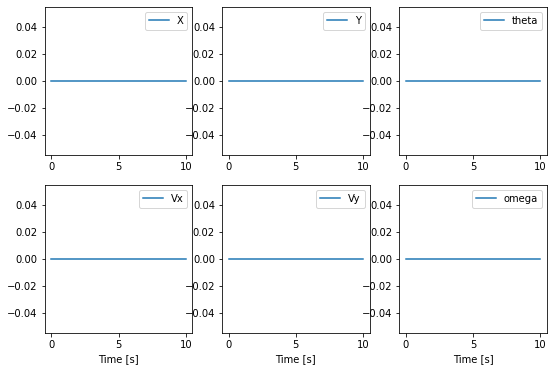

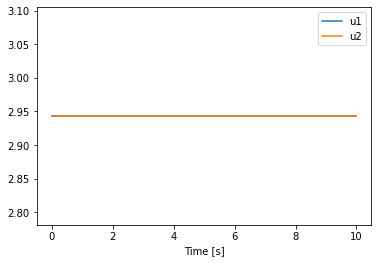

In [2]:
system = quadSys()
z0 = np.array([0,0,0,0,0,0])
t, state, u = quadrotor.simulate(z0, system.stableController, system.horizon, disturbance = False)
plotResults(t,state,u)

Part 2

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAG/VtZGF0AAACsAYF//+s
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MSByMzAzME0gOGJkNmQyOCAtIEguMjY0L01Q
RUctNCBBVkMgY29kZWMgLSBDb3B5bGVmdCAyMDAzLTIwMjAgLSBodHRwOi8vd3d3LnZpZGVvbGFu
Lm9yZy94MjY0Lmh0bWwgLSBvcHRpb25zOiBjYWJhYz0xIHJlZj0zIGRlYmxvY2s9MTowOjAgYW5h
bHlzZT0weDM6MHgxMTMgbWU9aGV4IHN1Ym1lPTcgcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhl
ZF9yZWY9MSBtZV9yYW5nZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTEgOHg4ZGN0PTEgY3FtPTAg
ZGVhZHpvbmU9MjEsMTEgZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz0x
MiBsb29rYWhlYWRfdGhyZWFkcz0yIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGlu
dGVybGFjZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMg
Yl9weXJhbWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dv
cD0wIHdlaWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFf
cmVmcmVzaD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9
MC42MCBxcG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAA
AA3vZYiEABH//veIHzLLafk613IR560urR9Q7kZxXqS9/iAAAAMAAAMAAOSq/2+9Zj+im+AAABXQ
ArISJA0agX3rQrxAFVDmjgk//Zy6/Zkysf1BBlzSMecs0adU4czxdWu3ATn6Hlfa1lvTJVwFeJzz
gStuUpMltOrgd3xiXeRyNijQbA3SBfm/fv33UGxcJxjDaZrIZWJfsESDGQ+3B//+mxNP94N7yss6
aV4av+XtWN3jEkYZZzhIObepWkEyfh6GARnZE3/T/+7ihF1wtiOqv7MNGcflxvs5VxV4MMYzAEvi
iKrzRZA5VD+NhenpB5TwMpaf2SkAXInoKf5Af1A3tfbNfkAbso+HX9qz+Esfjc8ahHUu6vK+1J58
JMjWbbInZn4IBKAAC7g6U1KoDtjXx85AOzj/JoDC5fVtr+A2m5QAIeNCly0DokANHjl4UjVOPHT/
bRdMMLhcHeFBpVmWjUZPnDxEPxnmdAd7QaqoofCuNL7WRoMmUl/wpZbIKnYPO0DFA4GiewEgMg2/
wpFNJwCw3zvnJ0b32ZekpfXy2tSyvQd0NcE2x6+cNbN/5vLsdqyWlRw2QlFf8t/MUhDvNJPuPJ+L
nk+q+lQ4eLo4KJc22S4/Xf+PY3equSdAKXPmUb7EdE2jhDuW/KNLo0niDiIJITmoYuC6VeG1cCu4
Xv2VqNhLgJbIE/MAN9GWy8MVq3JKMY05hpbR65Dk/eLsdAxzBAr2oVxGFkT/PhGfZthbWxjPO1OT
5VOuHlGmwU1d1p7J9Af9kY7lGkBHkYrI4yusPcYU4XXkiBBXmfdpxQAAAwC1CZjMyK5c22YBdQlK
gl1KkcCsRxULvj07lJvaE/1ct0s6EBTwzE+UWupyGTX9vO345aNs/wNQ/4V1buvVOI0dQeS4Bxhh
X5mv0vM2JtNBWPRyaS1ECKPL6/MdozqIzwP6cnd+HHSisYEZeG0gIqUymPTnr1IxP/pBgmgm8BFS
tWTTHjLMxQ60cYl1K4e1m3hC1onBHBwxxfWgha5UF0IMM7kaLaR+4aoPADApQhIzR07n9XFZae/M
2xV9fAVmwZw2MimGG+s+AyO59vHrTaHisD7u+EkA3Ul/6VA0wSQX49hJgXZ/W9lWxysKFt79X7H/
yAfTI/kR453FbNp/3gKU6XOuXYELBUYCR677xzJY8jBmACGX1+MAeK/zsGu+mtbxL7ZPFhEnCawP
8kOoFQicNRR7E9f3mC7scJ8KthYxtihjjid5Px+YW9slIHAMsHYw8jTVT//uVo18U8BijN/XOody
rDRtwSkf9n+WZveDVzHEdm7RXlaB3vpahReFffv+ZWjY4RjQloaVhDMPKbLF/iXba23gb7ftbB/b
ippoJPDRn/PkDfahF42lYjPGmZwpaFrPw2WRyevTofpHzYqYh/oupnaQfBlmc1xTX6lpUa0QZBAU
0kiEibdhqz/c7zcUvTAH1q2WbBAGWJzLLmiFYZ97LrZJKpes37LtNs56/mbZ9NHp/3TfldnTdTFr
8JGpluViunrsn9NTWWUePcZiCyf2tXJICmFx7i+CQAAAPOAbSwBHk3Y+XtLWKy0lY0QuSjdgkHUB
SohKIgw3izhpDbbZKupoQAqdzRJ9PESsZmW/P/8JqcVMa2UubRjtNTdy/Bk0LFfVm0qchnPhyOFG
gVNJQeYnEQfd/Ebhhbab8v+lBPqXGQ0nWfWVdy53j6TohoFaaXx7CzYie4PtA7mh9MFBZHl4nj0P
qWguc1TbYdXoids+r2deSpztR5RxQiwYD6nZrF6FL3bBy7+B1tQbqmiW+p0hvrRuEDXf/+ozBuaa
K6uKyB+IBB855UP2il/j3fDCgqD5MZPVmGk/FLJCHjBtvzZ9QAJwFR8wC22ES06Gq2/FNbNotC9M
/Ofus/yIXD6nMBS4BvWbyTRlur2JrFkBGUqj52FZfGVx1RvR0HaihV9bkQzRCRsd+avJEhHgYS0V
RyDJxwWMQVFwDJkl9teI1ZBiVlwNP9aLmzasuQ6Fdq2sDhEkgUYS9MR2W1xYrZwZLFBqejdRa+Ae
HNrpHOR9i/F6E3/s/r+/eI65advw4Ha/QkM5HRQN3eow+IUFgeEnZKriowd2put3VsRkdCF8iFGb
uRsdY7gvYPR67J1sBvxzPqdGDkaNnOJicZUia2Qz2kU/hpsq4Xso9NlXtbrf0sPq+qnkbgv7dgno
VBCbtJHMyOvXc1xWg1DDLYo48UzR1PsAAUa5WvBFYxnmwAwXwAAAAwHeXjBEVOw7dbYdvQSuQL5l
BOCl/qCKXDthitHkSalb2hree7YVfPxHoi4E4AtSTJtrDF1vOB3VO+AC2lXYySBrp3fgu1f26xVu
g67lHgR+faDU7vvblKtHiIbJmivVcySukQxa6RdczThgBTcpwBq0giiVs/4+XO3ueCJPx7x+GNZ0
5EMaVqnZE3E9vg2T86rt7DS/dD/HZpNYpn5HxHmaSbJjh5d3RJJ3ra7XryqTfkOkmH8m94WVyzG1
v3enXGhWvUHkWklWFbKeeF6+81E4iicTgjYfLSgZDFhrYhv77QdrXrG619xse7L7fAS1YjvofcIy
UCxhW7SEWfP5kbbmrKYrjVdF3UWkc/NhU5OCxw2I89+FXAFrPQdL4mT+lbD4UezjoK6OgAAAAwAA
g4FyGJUVGbOaqnILPPeo+F9xM1/dIhEujPTtuj9hz+HgXYKLCEx5hm3gLK/+4ND7IOUn37ZpysUM
20mA4VVareXWb+VQbU+syHYJPUwWZRTVZOjpH3RFVzZtQ4QdCvS1VI2G/WbyCBvNWiLZEffNF1c3
HGcG3iGCEFU2LKyW9wjh7WQs8hYln/bjom3HzesklxS+KXP9r9CQzkdGPJnMgNC9o0ibfrYXF+6e
eK8G37fUMWM9U6BjMFgDL

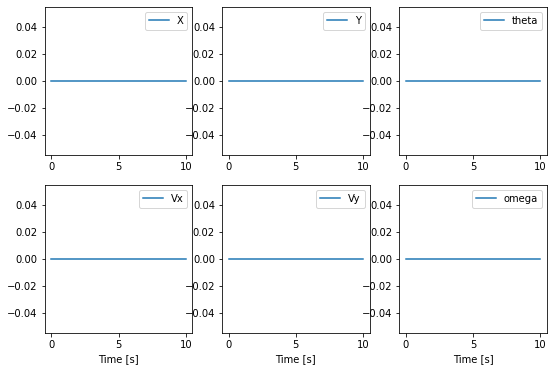

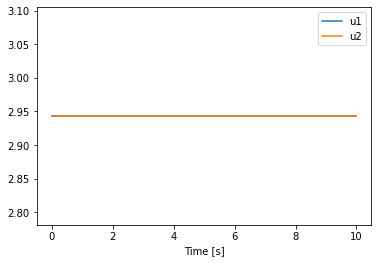

In [3]:
system = quadSys()
z0 = np.array([0,0,0,0,0,0])
t,state,u = quadrotor.simulate(z0, system.inPlaceController, system.horizon, disturbance = False)
plotResults(t,state,u)

Part 2 with Disturbance

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAATURtZGF0AAACsAYF//+s
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MSByMzAzME0gOGJkNmQyOCAtIEguMjY0L01Q
RUctNCBBVkMgY29kZWMgLSBDb3B5bGVmdCAyMDAzLTIwMjAgLSBodHRwOi8vd3d3LnZpZGVvbGFu
Lm9yZy94MjY0Lmh0bWwgLSBvcHRpb25zOiBjYWJhYz0xIHJlZj0zIGRlYmxvY2s9MTowOjAgYW5h
bHlzZT0weDM6MHgxMTMgbWU9aGV4IHN1Ym1lPTcgcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhl
ZF9yZWY9MSBtZV9yYW5nZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTEgOHg4ZGN0PTEgY3FtPTAg
ZGVhZHpvbmU9MjEsMTEgZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz0x
MiBsb29rYWhlYWRfdGhyZWFkcz0yIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGlu
dGVybGFjZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMg
Yl9weXJhbWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dv
cD0wIHdlaWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFf
cmVmcmVzaD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9
MC42MCBxcG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAA
AA4IZYiEABH//veIHzLLafk613IR560urR9Q7kZxXqS9/iAAAAMAAAMAAOSq/2+9Zj+im+AAABXQ
ArISJA0agX3rQrxAFVDmjgk//Zy6/Zkysf1BBlzSMecs0adU4czxdWu3ATn6Hlfa1lvTJVwFeJzz
gStuUpMltOrgd3xiXeRyNijQbA3SBfm/fv33UGxcJxjDaZrIZWJfsESDGQ+3B//+mxNP94N7yss6
aV0xgQdzqiPlj6UdKGO97DhjMefeF58La+qNumUnryH/93HhlMgfUFWAp7oxyaAbj2vu/4S0sZZh
ff37CJpYRDy8aiOtRaMpm1evJk7sCGfiaTKwjsoVVX+Xv8opVLz7pNYtlPE1q9279YAp4mSdScWZ
DyXz1heAJIUhS83I0dPO6p5gWRZ3gzPQUVX0T+eu+tjZrys6bfW4VkcensobHLNApudKY3raEiwC
Z0AAD27E4zpmcuQ/kwaqCISi9FB+fRz0lO1dtVbSHKQAYckhmIak4af6boBLcUDxTJiofr5DXRWa
AbhMzq7zBnlXu8Vp2Q9oWpzahMo53qW/eQf6ep2DztAxQOBonsBBjINv8KRTScAsPe75ydG99mXp
KX1Et5UZCA68Jo/BsbPOGtm/83l2LqRGPMVtHSiv+W/mKQfpsAYZ1OYVV3/LcMavjnS3b2+purlf
T//W1bvO0d8uuSj5djOGyRWRkeVy35RpdGfb3VvBHQoqC2sN/0yv7cDol//sP51M0Ih8yrAI339V
cEzRtuQDjP6Wiu8mcFQrt1tHUGMRUk3JMi9KaR5uJBtZr2OTFueapXrawCnk5+p09WO7uaYrutS+
Kes/AOOVnWidOw7zFkkDGO5RpAR5GKyOMrrD3Pl9Hsrp339I/Sp9eBPKwAAAAwFPgMjzr7gwzcXi
oKQLNUEupUjgViOKhd8Q7uUm9oT/Vy3Szn5VEDZip51tfMdhk9KQ83YQqWfgah/wpBXH+qcRo6g8
lwDjCR6SS5nM5xpqaCr2O/DPHVijy+uym4zxrjeW1Tk7vw46TfYvgOgNeN4W2G9aHpz16lRv9IOr
2nG3JjdUEwWEE8iRr1ylPMPiKcSK3X7tmon085C8666xCzpvKHpRYyJ0zumYYx6pKo2yTHLvvSSC
kxACyyYvxprUYhNpwPg3VXWUEYK00qyWn1ADsv6Dh3jWnEKPUnsqONt4oF99f7rSEm4owSo3dIbi
mVosN8h6vip5jn57os5QO0ypLpyiJEVf1Q17YWJnajFYq35TNfUAA2gn06pC1Ou9/Lg98Ny+j0UY
AArX0QT91zw/7O+dz7xh0ScJrA/yQ6gVB/uXp0WFf/eYLuxwnwqx+zmDdPHHE7yfj8vWvZKQOAZY
Oxh3F57Mf/1qgKJ2Z3XOUxfzLsMlDe2GX3ML+VkwcKA1yVHuWpcI4pvi9Brpc1FMhtWlmiSVbgM9
iRNW2mUeKi7lvxSI9aWo+i+52PUckIMnsQ2H+/J4u2BVZ2jgTiU+JgtmotKtpllhJ08eEMHxf8dL
j/MmGIGOuz/t/ubFrkU1LK/hex+paVGtEFo7Uakif9dcRuxC1ssi8u6sxzWWuiDxwMp9gl+8udxw
B2FxqVqPfz5hZ0S94u3JfAOhwfeD2J8VdnQ9ngoNUPDFs8I1aRYr1Hvq2NKvwBOXnGfbdowjWG90
gAAAAwPgxmK8Xb3mRpaU0S1oRW3qgFzasNMWmqHHZM5tizhpDbbZKsm5R3vYSP5EUNwuKiGofbxr
kQcn/S6YT2MGOdl1OYKqpwllJpXu22IwTaOIspltqj8ZOI1g2c875IBaICZrTLEQ9QRoOZXvlsbV
+4UI/sbZw+fkR11C1LsM6Kt5awbXNVQKXnU1fRyZHEtuE+B5Z8dvMDQWnI6NMV938v9mHTu7Jyo4
TyN3DQqA14w8Okw/vucEs5D3KABpKXb4P/JB3QCAxRjQa6W/OIIPT2VPv9IffSwmqflQnV8uypZl
DOXoBvytySFq7ZxUZ72YHugDeIvCeBq/QgVZJPUDWlmcy/q1dFCqgEaoyJiQbuVW0vAvDUOhXsW7
mUEcQF906AeoIUqm0V9Ak1a0uOcJAGkSc41o7eXh7DH4gv+4GuiAGVk+9bvteL42QspqR0SC4Z0z
WHd43GfpgXnAtHOkFGzR8AaKuNE8YBNNjpKFD03eXf1cbI1kJlHdRhplDK65d9TIbnWzz/v8MsHI
nMDorBAx0GYlXVanVSmGVB98AjIL8Ut6G5SIGpZKrvxEthuQt0Xt/yG4NqVsDA73ndScyjmoXPgO
FxnsNLwDQEn8whX//cRp+9+NgDyAAAADABGkX/ooS0WG376ikTlr5v405GWe/xA1pRZTTG469xt0
qOb13VdsKvn4jmtNZRO7Ukybawxdbxl3OVEgsdGfo5hRVdO78F0w7A8FwOy4efdUXZLYChidoGEA
bXbWFcoVR0TO3mC7V0Qh8Zpu0Rf+jJdUu33xFsEBXpLXvZ1Jt49+XRpyNjDcYl34onSLNlfzISy0
Wv6df0m4u5F2DHBbaQWgx+RleNvZ7irUHEjTH49Up3gs/+gLSOE9uUFu7Pl7HGjoj4+p6kxgfySs
p075fZqT/TkTSjJP3Kp2fgdk4QDLLywA3fkl5MXCTl7Y9IQoVG4nztVrNKQYtuVggx/aeKZmfcYs
3mx1Z5pZdABL7MMYAUtKfhAD9hImlGsKF4Ad/xtNcYy3QP6Nr/1L9RX7w5WyiZXxD4NKXJO0Cx5f
k/HJ0P74v4UsE69FXHVFihm2kwHCqwbNCfzfyqDan1mRBD3O/gqQfrT1KELdyzNXNm1DhB0IYP7U
7nm4vIAAAV20ZJAgVb9gMct7ZulWiX/RcFzOkcIh3/BS/F5xp/Y+A3WGkwmDL0E41HxshZTUjobr
/X9bdT2eT78JnLEm6WzIe

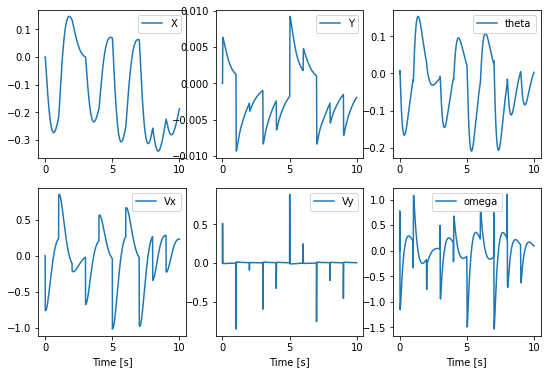

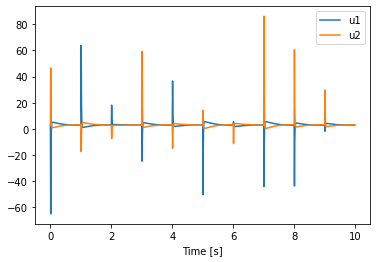

In [4]:
system = quadSys()
z0 = np.array([0,0,0,0,0,0])
t,state,u = quadrotor.simulate(z0, system.inPlaceController, system.horizon, disturbance = True)
plotResults(t,state,u)

Part 3 without noise at $\theta$ = 0

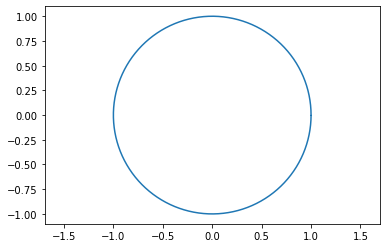

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAUFxtZGF0AAACsAYF//+s
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MSByMzAzME0gOGJkNmQyOCAtIEguMjY0L01Q
RUctNCBBVkMgY29kZWMgLSBDb3B5bGVmdCAyMDAzLTIwMjAgLSBodHRwOi8vd3d3LnZpZGVvbGFu
Lm9yZy94MjY0Lmh0bWwgLSBvcHRpb25zOiBjYWJhYz0xIHJlZj0zIGRlYmxvY2s9MTowOjAgYW5h
bHlzZT0weDM6MHgxMTMgbWU9aGV4IHN1Ym1lPTcgcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhl
ZF9yZWY9MSBtZV9yYW5nZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTEgOHg4ZGN0PTEgY3FtPTAg
ZGVhZHpvbmU9MjEsMTEgZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz0x
MiBsb29rYWhlYWRfdGhyZWFkcz0yIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGlu
dGVybGFjZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMg
Yl9weXJhbWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dv
cD0wIHdlaWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFf
cmVmcmVzaD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9
MC42MCBxcG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAA
AA6YZYiEABH//veIHzLLafk613IR560urR9Q7kZxXqS9/iAAAAMAAAMAAOSq/2+9Zj+im+AAABXQ
ArISJA0agX3rQrxAFVDmjgk//Zy6/Zkysf1BBlzSMecs0adU4czxdWu3ATn6Hlfa1lvTJVwFeJzz
gStuUpMltOrgd3xiXeRyNijQbA3SBfm/fv33UGxcJxjDaZrIZWJfsESDGQ+3B//+mxNP94N7yss6
aV4av+XtWN3jEkYZZzhIObepWkEyfh6GARnZE3/T/+7ihF1wtiOqv7MNGcflxvs5VxV4MMYzAEvi
iKrzRZA5VD+NhenpB5TwMpaf2SkAXInoKf5Af1A3tfbNfkAbso+HX9qz+Esfjc8ahHUu6vK+1J58
JMjWbbInZn4IBKAAC7g6U1KoDtjXx85AOzj/JoDC5fVtr+A2m5QAIeNCly0DokANHjl4UjVOPHT/
bRdMMLhcHeFBpVmWjUZPnDxEPxnmdAd7QaqoofCuNL7WRoMmUl/wpZbIKnYPO0DFA4GiewEgMg2/
wpFNJwCw3zvnJ0b32ZekpfXy2tSyvQd0NcE2x6+cNbN/5vLsdqyWlRw2QlFf8t/MUhDvNJPuPJ+L
nk+q+lQ4eLo4KJc22S4/Xf+PY3equSdAKXPmUb7EdE2jhDuW/KNLo0niDiIJITmoYuC6VeG1cCu4
Xv2VqNhLgJbIE/MAN9GWy8MVq3JKMY05hpbR7NW8x9/zcg3yQJNOjtHFUrCSsC9+favGiBwMRgot
gWFAaR1lJh7dws3clI5hnNAbJkjxPUnNS+jNvdOpyRXEkv4daXmg+sAA/ywy4DR9yQX8U4ZT8tGR
svgsi8l63bZlQ/MjbfakLacty930WmISFcB7ZyUlynhHsC1o0OSMkAbVCJerdsDLgVlSm1teN/Oi
LqumdHi8SWhRfPVejWolAomDMerxg46qsGvwJ+YgYbQxJvhCpYmZcgzJTvIM3LcaeGk+8S0zTZO2
cz8DUP9xCnjhdT9K3IPJcA5olt4fuZzOcaamgq8Jn3yauozhdKnaNkgUs5btU5O78OOkxFoMxgbm
tUar0plMenPXqJR/+AHnL6VpEtGE7I45n5SFDrRsYuT5qHqQ17YYTWrerMzmjS96eXsvCUG0BsTI
D+P/9nXTeOUMr/OupJGI1Ize/1Fj81t21YNtmXPvinntLWuu1mB8nVbDP2eFeRLfhgLOzp/mKvQl
vVnce2+bLD9gBgUWGX2rdOJaClk2IhJMUMuG/JkSTtDPqm8vitqcISu8F4LItNFhvkPV8VPVE+zk
9dW8xMXXzBuB0OgKNkiQbyIJIhXlh4o/0t0WqBzpy0x3+ns0BdQYSVoaoqqDW/L2P/FeGzoK4D+a
r7ivcypr5Yiz07yRopWDzjScRrIyqOa8KzzgzmlljzyLNtDBd2OE+FUbFOYQqfk81Z05ZDm5eyUg
cAywdjDyHfGj/9qWiidmd1zlL9vd/rUob2wy+5hf1XJAycscEmdTYybS2BcjRe00yjDpRspKDsQQ
DPBGexImrGIIfgl3IkO0ekwze3T/POT3Q4tRegAOBn6S3i6vk64ojYgiivFD6mzWgCMssJOnjwVt
ghnTnsxA27YA9XueqLXocqu8SG8p66QQLDLLSXiERqvr63MSu637UsZEAkfkiyw9WgQ+6I1x7H5t
VceT2gnWFnA7aqlWGkp8cMwiq6f8O6jgXM8dzzolp92E/q9B4e9BxSYpkyBnbo/H5+elfVUmrS5K
c0GSwk0yeJPGXeJCvvJdqhc+TlRCA3cevpWhhHn3UMTPMXgGj/ppOquys/Vh97G4IXbt6fgDQ3E0
pWAAABId+IXP0tz6lKwBhApc0wdPcQy7YTJkOtgkGvszfqibQwo8XtDG7QJ85EbBFxVJQOcCAkv0
fBL8SfITN3r7xBMwub1hpi5YNT+WM5tizhpDbbZKCAQ7/VOYkxovBf6zAinWVoE5SB12XLFfJuzv
H8+V63MFCaRC8hRjRhJdbC7l+qcfzuJ96EOuNYu0+srikgIYHsikM1VV7qTMsuZNz5oKMn7LPvas
6ZCRQw3CvEPSKzst4rRVGOJMaeyGEs6EdelwpuGUa8jGmHE/aBstHVO3l9G/O4roRfrmgaPKdwZF
A8jenLpkiuvFxB/NeUUNUA960uvgeLqFgfHnTmWXvQfdMx0Px157TA9kf8NXfdROXDNvb5u7l6e4
WNAdheGqiY7Ai0uc09w0tiOOWy6AhxOewIRzA+m6VeiVf3IKdrFn9YQqhNl7KJufBLXtRxR/9TQS
zbtcgnWOFrSN1QN5DORz+qEgyT5e97gPIpRimts6ksLlSARocFoNtpAWVFKl9MLsNcuPqP5dyDwf
vTdSlzCYqdUOijOJsfw8w0K3lYxvGi/hrry2GkixmTasYvX2d2R0ulDZUlBqzh35B1Xtev/jpUSf
shlb1xyn8VgwsNZdrdPE1lNcKn9djdJMggBP1GoNYAABwTQ1sigui58BaEFNQZZqcLhCj7/gAlI4
ad86qEEOmMNiQNqlvVEXyn3r/xWUTu1JMm2sMXW8lNzlRIFTE6ufGtnJv1INnn9agaV2Nza3oXHQ
ZGqXq2PAwgCzDawrk/0sRFbeYLtXREVu4u1+WIuEdoC2v4eGuNIj5cHFjYx4weH4Y1nTkQxlT//D
px10xxBvxcyfnVdvYaX3qfof5JWf/tXIVg+sAxoI7Gotu7okk71I6S5tyFYKgyUTOXe8LKUNkkNm
AjCFUbkqEHkWkrK0RsoLfw310WeUaJ61mgt2nlpZLtIE3aWXxZqvXdIuiVwcobJwaCgqghJ9fV0w
u20gMY5UIOg5oKb6fTDuLXKhCVm04Eh51S41IBGJj7xfeCahKRl5GtIpQTVCgvhDeuK7kpxdYFAz
j/cO6yxwFhtJv6TbfwNmt

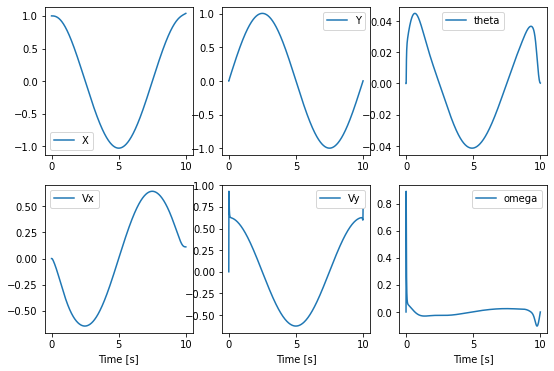

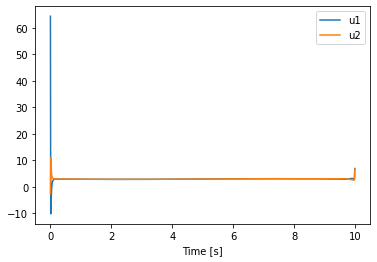

In [5]:
z0 = np.array([1,0,0,0,0,0])
system = quadSys()
system.CreateTrajectory(0,True)
t, state, u = quadrotor.simulate(z0, system.trajectoryController, system.horizon, disturbance = False)
plotResults(t,state,u)

Part 3 with noise at $\theta$ = 0

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAXHRtZGF0AAACsAYF//+s
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MSByMzAzME0gOGJkNmQyOCAtIEguMjY0L01Q
RUctNCBBVkMgY29kZWMgLSBDb3B5bGVmdCAyMDAzLTIwMjAgLSBodHRwOi8vd3d3LnZpZGVvbGFu
Lm9yZy94MjY0Lmh0bWwgLSBvcHRpb25zOiBjYWJhYz0xIHJlZj0zIGRlYmxvY2s9MTowOjAgYW5h
bHlzZT0weDM6MHgxMTMgbWU9aGV4IHN1Ym1lPTcgcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhl
ZF9yZWY9MSBtZV9yYW5nZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTEgOHg4ZGN0PTEgY3FtPTAg
ZGVhZHpvbmU9MjEsMTEgZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz0x
MiBsb29rYWhlYWRfdGhyZWFkcz0yIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGlu
dGVybGFjZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMg
Yl9weXJhbWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dv
cD0wIHdlaWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFf
cmVmcmVzaD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9
MC42MCBxcG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAA
AA6eZYiEABH//veIHzLLafk613IR560urR9Q7kZxXqS9/iAAAAMAAAMAAOSq/2+9Zj+im+AAABXQ
ArISJA0agX3rQrxAFVDmjgk//Zy6/Zkysf1BBlzSMecs0adU4czxdWu3ATn6Hlfa1lvTJVwFeJzz
gStuUpMltOrgd3xiXeRyNijQbA3SBfm/fv33UGxcJxjDaZrIZWJfsESDGQ+3B//+mxNP94N7yss6
aV0xgQdzqiPlj6UdKGO97DhjMefeF58La+qNumUnryH/93HhlMgfUFWAp7oxyaAbj2wOJ3pirm0D
ZxMXdFjV1WnNA0cDxI/14jBy3JVPJtNi7C311GKb0oCcK9AOQEAI4n/WxvTfZQJ1dZXLEYOKfDTa
8Qx6AO9jF2gX6Y3w617AElCixlBNBfRP5s67jmcp6OAHhAz+k3d2u9xA6LmpgBsgJQAxnsovSbKg
A/8APzne4VXEUInN9R2WftyJHO1PCAAkQihM1ZXShJ64VSR2z6nVBLsETArTtTfjt93X8zvGgO9o
NVTFvTqvzhVktrNiNahHw4G9aLpq5MX6d9HxPBZz6Nv8KRTScAsNdB6mrG99mXpKX2MfAcOeeog0
melC9fjKuzf+by7DRqfZpkdppRX/LfzFIPJ2aD7jsD6D5PqvrqsHnS3b2+purlfRb/fwqWWJyToB
aiy8GHDZLsHM9oxS075hU2FZ1lQ1xivPLxuVogkezC4XQpxLcTy3DWxeHIFTbEBc8DUStySjGGTO
QDnKHhaF+Kei5XZJBs4dzE/EsW9P77Ap9q898h95w3qion9bA/WSE9PbuG2385WRalie6ySBjHco
0gI8mHLI4yusPesCEO8/1CqRT+LRWO155gABrk4LJFUiXX79cYxVAeSRsvgsi8l63bZlQ/NG17/l
J8oPNrtLvsjs+5NF7p0cxVVuA9s5KS5Twj2Ba0doOldoPUTn2kf8t7AAXXvI3lgMaUketp24oIQ4
jtLi6GkngXNouqzflwkNhFHZnXvfIPa00dJ3fEu5IviWzI4eH0ee2BMThIIhJdBEe3jy288nLDMI
DJLWqjGOGLqsqrfvBZdCvqYM6QJiE3RekPvk6aFYTA0ZpR6QYY9g3FKLrxSGKKAchcY8oTC9olxn
udR7R3IN3/0ghEbLLCoAiGgy7lfEmEqtFygIKaiYrsmYsC6Q4TsHOYZf7XoLM8LlR8O4mQH7n/3f
cPFZsZv9c+y3gbrzcFguiquqKEk6hwUQUkbSXs8g1SckKB6+VfBUTB+ajKJpgCzT8O2exhppTkey
U0JGILl/2RxsBUaU7cOO+Al4LisAGuHWp8TyBnwkcxvjRiaFI0wM1HfyzJNn9Xw+dzXHTae3CJRS
LJp84quxnagzuOowY34F9tGCDyv1yhufeh1YPQNzu+gyEPuaXg/UDbN8/wYmZF6iP40EFWNqSIgA
ACL5EznESzC2A70+4ioXnIE3Fc+9jMd4QAv5b5lQANAe5REuBu7tLNLdIP1m0dFv4tmi7WdUqrgv
2/jYrAncfJjf/8DQszFWGDWv2bUU2PPqZ2uMiUB/PjdoQs8O0Q8EVM4tkBQBTk8AeaFh8RVGw9Qy
twGexImsugNjGl26WyK9rssKs+7uYYD9dsOJN99J+lMYv9kb3VEiTeS/jm/nJ7Y1QZCrjZo4LBfe
aQxxTubM7RQOnOlN4cqDXSCBYZZadm0r7PifSLigd9opZWLnv79medHgRlEcfW5/vZmYek0TrW7Z
Js42pbtzey78dD0qL518OG+31or71fwkAdyNRWPDHWcr/lM3IPO5SHwFCwPOszR2F8BIdptKgvMi
/gEYOSg/mdp8TKWO9Mil+FBKF7/vwE4k+6AGFG9e1vzZusqzP74AACibNznfQtvzXFU+/57ToABy
BAvqHBkBnhbf8q+SszK/7dCVXUYSH/z7l9R/ol0j/J8Luma+fh8De+91g6LbBSumlzm2LOGkNttk
uF4EFVZIcSyd7KS+X+Mbl7WHRBXVX3rPQlOVwJRX/3qkvf6g2BAoi+zrAOnmP2IWGhAi3E1auCGk
5e7RPh2vHvkTThdu8zuV7c3j4y20p0+ZAuQxz6Qaufe9QUG8ROkcs07lnTYBK55xJ9gjx3f7RkCD
x2/NDkD56m+5KF0FHTOd0W8p6zpYnXiZx58swBqzH4XKM07LrUo8Si+u34IeUM0X0MZPnNv/wPTA
E9EIukCOWJ/c9Lg37ygMKhAoq3Rp3lYUjwoU5PXkV2kKakpgfdHORvgXpqDAbkmSebW1O88x9bu1
DtFIEO2eBc9GrdjgZJ8cb2xd4FL8Xnuv4LeliRYuGVXmbubftfoSGcjoEtafVQQoupzMZKLpBre6
eeK00gE85Pnltuhr5cVRth5dNb+r7rl4orcirtx1GAbNJo1yJS5ZnX/luW0n0CuvE/m/9TKrKUlJ
K0gebjyNJzCwBBy3cGauS4rDEhoVUqqXxb2rtRA3R5hYWuZcCdx6QPR1oAV/L87DHy3JF47otFUY
mgAAAwAAAwAAG/CIBzAPKC2wv/MwuoYU5k1wWX5AJSOGz7j1nIlAGM+l0fHvV4f4n3shokCGn9w1
E15ME7LcOt8De8drGszCva6d34LpVvtUBkYY6H2bg0yRql6kR0tOs/QIbJmivVcMoLP/4WvFlTkd
St+v1F+ZNuJb2WHa9Zz827lm1BC2fJ/PCj6QiGNM//Z0/wvk/k+XFzJ+dV29hpfcr91l9hY/8nN7
JD7eN+zkliLzczzPETMB5kf2FOCb1Ay5fvvNWUobJIbL6yfqo3CwDsItJYDA8eU3HTNiiCn0jozn
lpbY5/8Aq6yjkPx4/B6e+bsX6ZaMj8j70woZ0EB0+ZAKpDidmY5RqdPg26dssGN/WgAAAwA3AAAE
q7vCYsNbZIgfLDCKCJltI

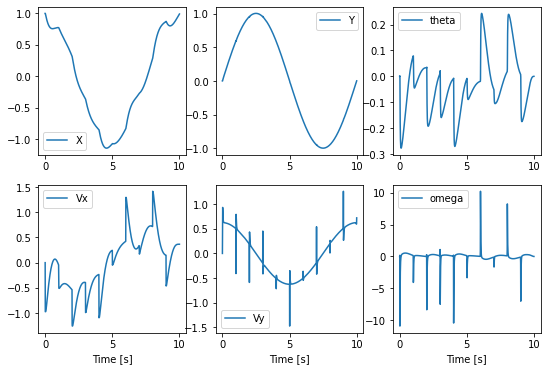

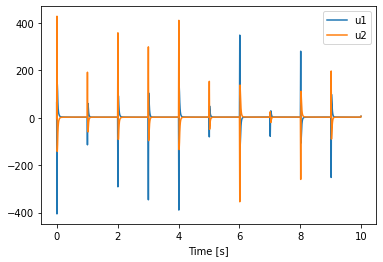

In [6]:
z0 = np.array([1,0,0,0,0,0])
system = quadSys()
system.CreateTrajectory(0,False)
t, state, u = quadrotor.simulate(z0, system.trajectoryController, system.horizon, disturbance = True)
plotResults(t,state,u)

Part 3 without noise at $\theta$ = $\pi/4$

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAVLhtZGF0AAACsAYF//+s
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MSByMzAzME0gOGJkNmQyOCAtIEguMjY0L01Q
RUctNCBBVkMgY29kZWMgLSBDb3B5bGVmdCAyMDAzLTIwMjAgLSBodHRwOi8vd3d3LnZpZGVvbGFu
Lm9yZy94MjY0Lmh0bWwgLSBvcHRpb25zOiBjYWJhYz0xIHJlZj0zIGRlYmxvY2s9MTowOjAgYW5h
bHlzZT0weDM6MHgxMTMgbWU9aGV4IHN1Ym1lPTcgcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhl
ZF9yZWY9MSBtZV9yYW5nZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTEgOHg4ZGN0PTEgY3FtPTAg
ZGVhZHpvbmU9MjEsMTEgZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz0x
MiBsb29rYWhlYWRfdGhyZWFkcz0yIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGlu
dGVybGFjZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMg
Yl9weXJhbWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dv
cD0wIHdlaWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFf
cmVmcmVzaD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9
MC42MCBxcG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAA
AA67ZYiEABH//veIHzLLafk613IR560urR9Q7kZxXqS9/iAAAAMAAAMAAOSq/2+9Zj+im+AAABXQ
ArISJA0agX3rQrxAFVDmjgk//Zy6/Zkysf1BBlzSMecs0adU4czxdWu3ATn6Hlfa1lvTJVwFeJzz
gStuUpMltOrgd3xiXeRyNijQbA3SBfm/fv33UGxcJxjDaZrIZWJfsESDGQ+3B//+mxNP94N7yss6
aV0xgQdzqiPlj6UdKGO97DhjMefeF58La+qNumUnryH/93HhlMgfUFWAp7oxyaAbj2wOJ3pirm0D
ZxMXdFjV1WnNA0cDxI/14jBy3HipmB7UrSKAnCvQw+w34Sa8KqwJ4Z4IfeRXyTwJjfpsg5xRNoA7
2MXaBfpjfDrwcENv9sucIc29E/psQ8kQssWrUiTTN7YfDFocAAEZPFF2JFeYr/szbAqeCQUBC+7T
aRkIRXj4kxhEgBfYac/1pfXL3uq5MRDs13wG1FNy8Wxk9oiClzncvCHO2eflWmvenVfnCrJbWbEa
1CPhpt60XTVyYv076PieDPfqx7cU1hzO1nl4nzk6N77MvSUvsceA4c89RBrxKIC91nDWzf+by7HY
q2/B8KI7boendpI3YyppJ9x4MxB9GNPJawa4ujgolzbZLkDX/y0EiJwjzUAt6bVRzWW5AKOEO5b8
o0ujSIS8jP4pZ4R9QbD0ASPZhcLoU4luM5bhrY+0pgDD09c8DUStySjGGJuQDnL/aqWVUDULdifi
WLen99tBDxQUtDw/nu81tvgUN7ChF5PvcNuGJMrItSxPdZJAxjuUaQEeTDlkcZXWHvWBCHef/KBV
klwdBDvSVnnAAAADAXYAgr2384dbiJSwEdSQ70wPXUSYylBeNY3TtzNLR909ZbpZ0CGoaGJ8otdT
kMmv7gdvxy0bZ/gah/vp8mP9U4jR1B5LgHGGwWma/S8zYm00FXloVCMdWKPL69l3DzJJby2qcnd+
HHSgPoBGnd1TLVkqSHpz16kQ3/sBKLQdaAe+QhW+OZ+UhQ60bOMbvehPDNsLWicEcHDHF5xn3HNE
pAgwzuRotpICtVTxMPycqSPoKAeiCz9cnQ4sM5LL7V2UEYK00eyWdWioBkdz7ePWnEsbw9Ch9T9/
LC7Ki0/8+9272l+DeHMUXZ/W9lWxysKFs6RlxjLQfV8CbzA1yQWA/Bwy2Y6ZsiUj8taGhexb87AA
AAMAAoxh8NU063cuWY2upbqhznUMPe+ikeYZLeIkeeRZtoYLuxwnwqWrZhiVPyeas6cseMTZMhT8
ZHhTjDx7j1P/+5rUPlSJYWI5bbhK+1g49xKFoB8fvnN875+1OMLgstQ98BaylPedhX6sozKRBDeO
q5BEKA+AC4pssXj9Xv2vo63R8YA7JhAijdu+Qf/PiDfVFbAVBs4bf0OLUiHHRTLLI5PXp0P016hT
6pVo5UQjTDR+hImGf+NOAZH2yUG8RWAWHR8GSz+kL67Br9td3NUJlWupeNcIaeV4DDcLpfvUn6TE
mxCpt0GVXinjTp0o/nUX0+in1sklUwOXS/dkEkiVokIzcDmmNZzG/SO0zXFyIEjodjP03smNoLIt
ErDnAAADAAIwVGiUmQygvUXvtB9woMmfeSmZg/IpayjK+WwPb1R/LuJBo5ExqfQzgdrd/ZKIwkmg
4h+hf3f6QX/8PHoy2kz3AHuvxsHZNTcw5LAJWjW4RckgE9guyKCcguGPqejkQKkWT8J9QoeD+CEO
MWlIojs+FzjdL4D+be1CKBae/ihj/9a82hhCsSgmjiciMM9Snw00odq9apMvDWRGGDvHOwYrGmAI
EUSnOd6TX5Lh9je3ihJf9fpbKnml4lIajxs2NG8x9p4mMzUNbUORahojpZ3vPaLmHnfx5toBvkmt
+fXmsBB4Z8S5bB5hkCy3/jkaFmaYak3vm7uXqRq91kCLhRzR28EgOszw7Nqy5DoV7HKdTGn64JGf
TJwxBVgjwcvc0Rbvt1fFg7aUC7+DQWeQsvu/o5WfL+AEY0nXG41Ivmo0Z2pHRR5UFgFB+d5YHPhu
1iawwHnCOh0Scilb4XxvSzAieqMT1IupdCWA2vPaVHt5R3Ks2OwGp12diwZU1n+Ls8fyo79B61kM
8Z2r8mH341vlEAyb0KDO/AVCL+0+HCoNj2cj0CuncwIxNaRBQ7IkFl2PYViOUypIkilzeCnVZuxa
mawlz26BbauwEl6SjOz+HJqUwYBhiE3Kx5mqOHvVxrfiNfGhNG1///l389mYAAA7gANbXcLU+AkW
U5MdNyKDjPab2xppRoef0AadVTdFIJu8bSf+xhp9i2pZN6SZ7zsjfIeakmTbWGLreRG5yokDoaAb
itFWund+C69M16IsOkbFm3cGdCAsbrXG9p1o8RDZM0V6rh2i65wlkdWHv5/oOlnf1nAcfTUxTDRI
/AFci4kn9BuE6vmwpQ/+dPUaIVZ9ElLgLmV/XC1QPt+YvklUx78yR6Ifgokxjsai27uiSTvmWGlK
T2wrYa9FFj77zVlKGySFt8guZBNqyoSxKJ6mX0/onooVCKWLpa1xssOsM/GXKmHIrBCvLaTSUI6h
r9VArgG/nf/ZEmEjVQC7yw4Eyp9jwZzh16TZY4IRp4UTu1zjaZZ0U17fdttKIcFCombvBiv7aTxM
Wpifm5uFcwQC6LHHHDAA47e+lPcncSguHuTpjo9NCAOAfp89iSXpzN0shoTtDNgi37HaHi25w4xY
qjpSem1L9lsPoHlTOaxdDoCB0rQapm9b2bZAR2NDXGeg0KJ3/1s3Ra/iH1MCx1RYoZtpMBwqsvCc
SE7Z4d27WhaVEljAYMqQfrT1KEJ5lMzVzZtQ4QdCGGialoCvk0uLp2eonb/shBPsxsxa5XdbHH/j
h4Xx7Q+EtfNPab/3gUvxe

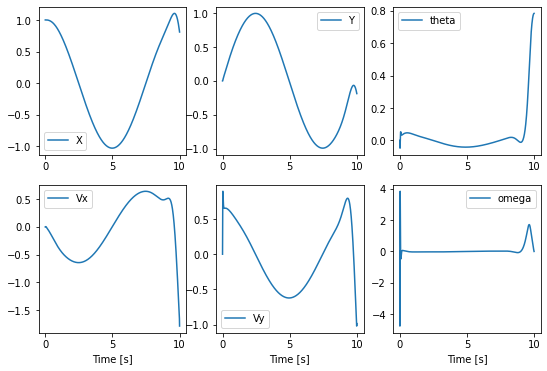

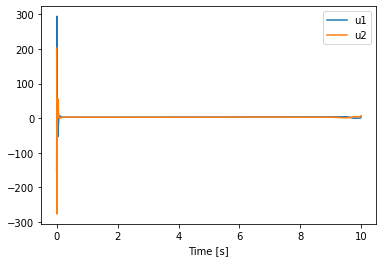

In [7]:
z0 = np.array([1,0,0,0,0,0])
system = quadSys()
system.CreateTrajectory(np.pi/4,False)
t, state, u = quadrotor.simulate(z0, system.trajectoryController, system.horizon, disturbance = False)
plotResults(t,state,u)

ILQR task 1

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAT1ptZGF0AAACsAYF//+s
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MSByMzAzME0gOGJkNmQyOCAtIEguMjY0L01Q
RUctNCBBVkMgY29kZWMgLSBDb3B5bGVmdCAyMDAzLTIwMjAgLSBodHRwOi8vd3d3LnZpZGVvbGFu
Lm9yZy94MjY0Lmh0bWwgLSBvcHRpb25zOiBjYWJhYz0xIHJlZj0zIGRlYmxvY2s9MTowOjAgYW5h
bHlzZT0weDM6MHgxMTMgbWU9aGV4IHN1Ym1lPTcgcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhl
ZF9yZWY9MSBtZV9yYW5nZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTEgOHg4ZGN0PTEgY3FtPTAg
ZGVhZHpvbmU9MjEsMTEgZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz0x
MiBsb29rYWhlYWRfdGhyZWFkcz0yIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGlu
dGVybGFjZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMg
Yl9weXJhbWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dv
cD0wIHdlaWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFf
cmVmcmVzaD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9
MC42MCBxcG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAA
AA3eZYiEABH//veIHzLLafk613IR560urR9Q7kZxXqS9/iAAAAMAAAMAAOSq/2+9Zj+im+AAABXQ
ArISJA0agX3rQrxAFVDmjgk//Zy6/Zkysf1BBlzSMecs0adU4czxdWu3ATn6Hlfa1lvTJVwFeJzz
gStuUpMltOrgd3xiXeRyNijQbA3SBfm/fv33UGxcJxjDaZrIZWJfsESDGQ+3B//+mxNP94N7yss6
aV4av+XtWN3jEkYZZzhIObepWkEyfh6GARnZE3/T/+7ihF1wtiOqv7MNGcflxvs5VxV4MMYzAEvi
iKrzRZA5VD+NhenpB5TwMpaf2SkAXInoKf5Af1A3tfbNfkAbso+HX9qz+Esfjc8ahHUu6vK+1J58
JMjWbbInZn4IBKAAC7g6U1KoDtjXx85AOzj/JoDC5fVtr+A2m5QAIeNCly0DokANHjl4UjVOPHT/
bRdMMLhcHeFBpVmWjUZPnDxEPxnmdAd7QaqoofCuNL7WRoMmUl/wpZbIKnYPO0DFA4GiewEgMg2/
wpFNJwCw3zvnJ0b32ZekpfXy2tSyvQd0NcE2x6+cNbN/5vLsdqyWlRw2QlFf8t/MUhDvNJPuPJ+L
nk+q+lQ4eLo4KJc22S4/Xf+PY3equSdAKXPmUb7EdE2jhDuW/KNLo0niDiIJITmo7O87YgTYV2B0
keRinoI+OF75RJChLhB0Hcej/z9GcMXuQUExQWFs44aH+mtTRP0i7HViFR6BEvM1yH2nye5WxcUY
W3U68i2WEm1Trj4fjI/D11p7J9Af9nlPlGkCUjkU5xmFYe4wpwqsWcvhkLd2lpAAAAdoTMZmRXLX
FdAYkJSoJdSpHArEcVC749O5Sb2hP9XLdLOhAU8MxPlFrqchk1/bzt+OWjbP8DUP+FdW7r1TiNHU
HkuAcYYV+Zr9LzNibTQVj0cmalSEBrItZL4BdsgMy/6Dju/DjpRWMCMu4KQEVKZTHpz16kYn/0gw
TQTeAihbyLfHM/KQodaOMS6fMPazbwha0Tgjg4Y4vrQQtaa5eomGdyNFtI/cNUEwOStlldPgNkBW
S7fiBTs2xV9fAVmwZw2MjosafyN8v6DhkgqfBA94H3d8JIB7TX/0qBpgkgvx7CTAuz+t7KtjlYUL
b37n2P/kA/eR/LkM9uLSbT/vAUrkudc9wIWCowEj/2HQjWOyM2YAIZjX4wB4r/Owa76a1voQtk8W
EScJrA/yQ6gVCJw1FHsT1/eYLuxwnwq2FjG2KGOOJ3k/H5hb2yUgcAywdjDyNNVP/+5WjXxTwGKM
39c6h3KsNG3BKR/2f5Zm94NXMcR2btFeWosUql3pOwr7+AzK0bHCMaEtDSsIZh5TZYv8S7bW28NK
gboKLHaNpuIR2zr/58gb7UIvG0rEZ40zOFLQtZ+GyyOT16dD9I+bFTDm9Z/zM1P1Zx6xNmncqLq7
3eD7FBv835SSAFQM99cnZYYvLurMc1lrq5fKkBqBgSn7WMO7I9t0RWSC4bo02rlb1HB5bJXI88Hs
T4q7O16mLX8Rp+I0IJ/Ruwf1HjrQVzVcGXuT+1q54Ftwssp7fL4ASlgAAoq3bwYyDVfc/YbBFsln
dwU1pYLLSVjRC5KN2CQdQFKhcoiDDeLOGkNttkrTYpmH8psQ6TsCp2UHb4OT1Y9P/8ivc/9hDf1i
hnV2t/50mrTs81WTwdYLgNzCGftQuEpO0geiWK7CD9ALZn5yuDirGCY25XaQ2Uywy7fM9xTvB9oI
hw3ddn5Rf1/3Gue72fouALhe+JAlv43NEJhUDp+DE52HTrqLaX4LnfwZPuzqPV88tnP7FslN9+4/
5MmHHgURYSWX6m7KB7DXwS/2WsLjKIAODD1DiI5BNVxlAm2g7ueaS4mL2uK2vS/P5bA/SoNpsHct
qS5TQe9Qtq1kn/MyP5bl0dxaOwJS5wRBk7Qn3UBzXW5JGpaaEfoU45uDbAi0Xf+L9OebOInLQecZ
JkequIEd8tiEKuYH2iGfPZ7ZpbEcctmWSevUPVbf////q7qSX/BdocooSg+xt6JCdH+Z8Be4Tqsu
nW0+hbk3wu0Z+fddVxfGyFlNSOiImW+yRcC9qw3djscaJiQyNP6WHuZOyZV/qkX+u5FCNcl8JTXJ
6vYknG3xz0mxpCrknU6J/WOb0FWmAwiS2r9sycg60HlQyT+o5KzPpXnH1i9qJ6mLRd1eCX1rSHQM
8MGC+yUd8+RumURSsAE0GwFvahO76G8sV/i4Y4CWXdQ+0pt1YiuuzHJm0JcDSTpMAAI9x1rbn2jf
THHTuuVUlXP21OM/9gNaUaOJK0eRH8Kj0uj496vD/E+9nRFUFT+4aia8mCdlnWymT1HF/f4AKCn6
i7vwXSbwjb16Y2HV+ueY+0Gp3F0PKVaPEQ2TNFesZFfHc4SyOrD38/zOOFzbBqsT9waRnPP8IjiR
0GboHrlmR4fI2MHTIu/JLhGLmV/MhLLRbBF7/Ohxgn5s0G0/Sq1Ht9j6SKM2sVe+x7XnmxJAl6Ep
Y39AgokJmbh1HP2wkIbDeNYB8yCpkskGPSyzg+6ft8r7kTSi5FTGrLf/3rdMTYN+QoAgXmtMvma1
pR/5ND39vnQKPL05BO6UCxhW7Rsa68KF5Am/L0OMXKQ65z4ClvLzSKhXLXzp06YYl2SgUXBq96cz
hPWGv+zprW/oDbwFunNKQGYSaYhLD5WwXevfji6o+33e8XAEZlSvkj7qdmf5JlRAaGBn5iG60tod
NedeZf5K/NOhwavtaq5eK4MKFq29xAdXP4ePudubyrGCNYfsb4gBH+lUMgjWtdKtE7hKSWc77CAG
Uj7F+LzhD/Po2dQbsYmQZChIEO1+hIZyOhk8LhDfkHtg0SjXizBscI4qzMMwdgPhZHja6azgi54M
h/XsgbDm/mXZmzwtjJTNp

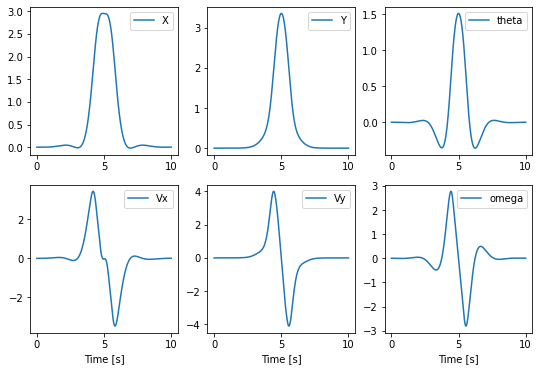

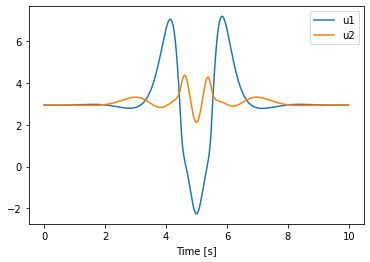

In [8]:
z0 = np.array([0,0,0,0,0,0])
system = quadSys()
system.ilrq1()
t, state, u = quadrotor.simulate(z0, system.dummy,1000,disturbance = False)
plotResults(t,state,u)

ILQR task 2

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAWmdtZGF0AAACsAYF//+s
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MSByMzAzME0gOGJkNmQyOCAtIEguMjY0L01Q
RUctNCBBVkMgY29kZWMgLSBDb3B5bGVmdCAyMDAzLTIwMjAgLSBodHRwOi8vd3d3LnZpZGVvbGFu
Lm9yZy94MjY0Lmh0bWwgLSBvcHRpb25zOiBjYWJhYz0xIHJlZj0zIGRlYmxvY2s9MTowOjAgYW5h
bHlzZT0weDM6MHgxMTMgbWU9aGV4IHN1Ym1lPTcgcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhl
ZF9yZWY9MSBtZV9yYW5nZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTEgOHg4ZGN0PTEgY3FtPTAg
ZGVhZHpvbmU9MjEsMTEgZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz0x
MiBsb29rYWhlYWRfdGhyZWFkcz0yIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGlu
dGVybGFjZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMg
Yl9weXJhbWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dv
cD0wIHdlaWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFf
cmVmcmVzaD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9
MC42MCBxcG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAA
AA3PZYiEABH//veIHzLLafk613IR560urR9Q7kZxXqS9/iAAAAMAAAMAAOSq/2+9Zj+im+AAABXQ
ArISJA0agX3rQrxAFVDmjgk//Zy6/Zkysf1BBlzSMecs0adU4czxdWu3ATn6Hlfa1lvTJVwFeJzz
gStuUpMltOrgd3xiXeRyNijQbA3SBfm/fv33UGxcJxjDaZrIZWJfsESDGQ+3B//+mxNP94N7yss6
aV4av+XtWN3jEkYZZzhIObepWkEyfh6GARnZE3/T/+7ihF1wtiOqv7MNGcflxvs5VxV4MMYzAEvi
iKrzRZA5VD+NhenpB5TwMpaf2SkAXInoKf5Af1A3tfbNfkAbso+HX9qz+Esfjc8ahHUu6vK+1J58
JMjWbbInZn4IBKAAC7g6U1KoDtjXx85AOzj/JoDC5fVtr+A2m5QAIeNCly0DokANHjl4UjVOPHT/
bRdMMLhcHeFBpVmWjUZPnDxEPxnmdAd7QaqoofCuNL7WRoMmUl/wpZbIKnYPO0DFA4GiewEgMg2/
wpFNJwCw3zvnJ0b32ZekpfXy2tSyvQd0NcE2x6+cNbN/5vLsdqyWlRw2QlFf8t/MUhDvNJPuPJ+L
nk+q+lQ4eLo4KJc22S4/Xf+PY3equSdAKXPmUb7EdE2jhDuW/KNLo0niDiIJITmo6g1iBNhXYHQo
vDauBXcL3yiSFCXCDoPKF5SL0Zwxe5BQTFBYWzjhof6a27wAwLIdWIVHoES8zXIfafJ71+hsPC26
nXkWywk2qdcfD86PVgjPlwoQOYVzQ+UaQJSORTnGYVh7jCnCqxtl9DHae/k7oAAFODSnttFzDmd0
DEhKVBLqVI4FYjioXfHp3KTe0J/q5bpZ0ICnhmJ8otdTkMmv7edvxy0bZ/gah/wrq3deqcRo6g8l
wDjDCvzNfpeZsTaaCsejkzUqQgNZFrJfALrMBmX/Qcd34cdKKxgRl3BSAipTKY9OevUjE/+kGCaC
bwEULeRb45n5SFDrRxiXUDWJs1d1p5S1ieBnAiODhji965C1obLoQYZ3I0W0j8ZhES+zK2WV0+A2
QFZLvbXvOzbFX18BWbBm3wMtebp/I3y/oOGSCp8ADRf+Y8mRQDdSX/pUDTBJBfj2EmBdn9b2VbHK
woW3vhfsf/G89Mj9hHzncTs2nvfgKkYd8S442gsaC3vCCcE1JrThEJRsOSwAECDaWsBk+POwa76a
1wHs6six0ScJrA/yQ6gVCJw1FHsT1/eYLuxwnwq2FjG2KGOOJ3k/H5hb2yUgcAywdjDyNNVP/+5W
jXxTwGKM39c6h3KsNG3BKR/2f5Zm94NXMcR2btHlCUtfMuggXhX38BmVo2OEY0JaGlYQzDymyxf4
l22tt4llA3QUWO0bTcQjtnX/z5A32oReNpWIzxpmcKWhaz8Nlkcnr06H6R82KmHN7EA7ibaMjn8/
ycnxfsjk9enRBqsCzSShkcTCCglhMMXl3VmOay11cvlSA1AwJT9wf7dke26IrJBcN0abVyt6jg8t
krkeeD2J8Vdna9TFr+I1AEXEFCw3YP6jx1oK5quDL3J/a1c8C252WU5/okAPeoAAe8QvoMDI7n3k
VYmQkBR9GD0o4/UhA1SNt7PfbBk/LBOlfaTObYs4aQ222StNimYQyzRQpOwKnZQdvg5PVj0//yK9
z/2EN/WKGdXa3/nSatOzzVZPB1guA3MIZ+1C4Sk7SB6JYrsIP0AtmfnK4OKsYJjbldpDZTLDLt8z
3FO8H2giHGit2flF/X/ca57vZ+i4AuF74kCW/jc0QmFQOn4MTnYdOuotpfgud/Bk+7Oo9Xzy2evs
WyU337j/kyYceBRFhJZfqbsoHsNfBL/ZawuMogA4MPUOIjkE1XGUCbaDu55pLiYva4ra9L8/lsD9
Kg2mwdy2pLlNB71C2rWSf8zI/luXR3Fo7AlLnBEGTtCidQHVdbkkbbtmF+hTjm4NsCLRd/4v055s
4ictB5xkmR6q4gR3y2IQq5gfaIZ89ntmlsRxy2ZZJ69Q9Vt////+rupJf8F2hyihKD7G3okJ0f5n
wF7hOqy6dbT6FuTfC7Rn5911XF8bIWU1I6IiZb7JFwL2rDd2OxxomJDI0/pYe5k7JlYDWo5CDmSh
lB45tKKSBRj/JqMlUNyUp4tnjtQVFGYdPkPvx4kO8mcUMMyvKQerYexvGGcdWYwgU/vG5gpanLEU
oveHxPRhfzLjV7Ipw0jCS+plSI/KgAACyzH/+9oh+AAABx14RY67+jhueU+wpR7FgANeEDP/gCUj
iUs5WuOe41W72OapxXDhh8Rzq7JNkzUkybawxdbzgd1Tvgx0nzWjwosB5i5mkz84g+fCDg6v1zzH
2g1O6CstZmk2VW79OFUdFzSfgu1dEIfGabtxlhwujmgGnxk6yOKsUcFZZpE28e/Lo05Gxf+T4z8N
ddZxupmQllotf1//rNZdyRWOf8bY4LggvH0kUZtYq99Q6VIvgiPLv7AGOut/QFpG1NX+ZPGLFKqV
qO94wUwiPYBj8mrJzCV4+h/A80gWFe5IhI9eEgHCX1qPNTKk6YzQ+ghcO2Hz9HcWKMOyQ89SsTGF
btCayZ+MAAADAAADAAAJyMHso1ZgN6qqcgs896j4X2+GP8uXwd+z5ZIt8EcH+EtWCiwhMeYZt4C3
Y/rF0XY9vTlfjHPhQ44WhdoRQYT0J/N/KoNqfWZDp7MxLkIK4DzA3LlTqIqubNqHCDoQw5lE7Lvs
00cj0+dRNaBQIv+s+PXKGnBt4dvFTRmz0O6VT9SWH7wKX4vXX33g/Dj2KZEJ51EkDF8bIWU1I6KK
KyZzsAoTEhvZVARo6SMwdgPhp46L23x+WIAPUGb3wzuh7uFX8hjLBHKasptI3X7fnEfv7kaSW6oq
/wyGhfLmUlObOOHCzYhOj

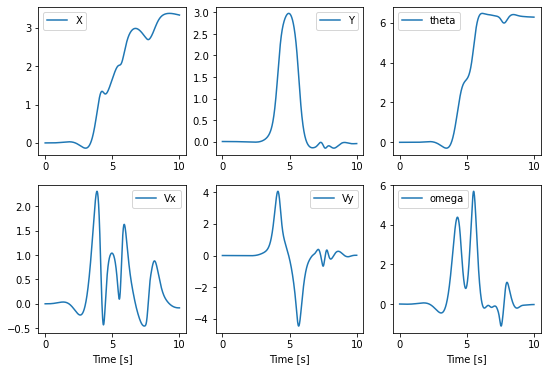

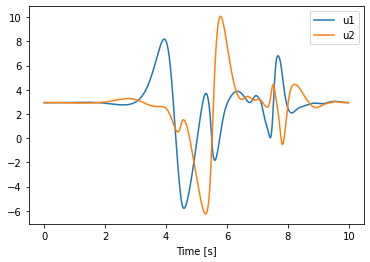

In [9]:
z0 = np.array([0,0,0,0,0,0])
system = quadSys()
system.ilrq2()
t, state, u = quadrotor.simulate(z0, system.dummy,1000,disturbance = False)
plotResults(t,state,u)